<a href="https://colab.research.google.com/github/thdgmltjd123/Assignment01/blob/master/Assignment10_20150711.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 구글 드라이브와 코랩 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***Computation Area***

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import numpy as np
import pandas as pd

In [31]:
transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307,),(0.3081,)),
])

In [32]:
# 부모클래스 nn.Module로부터 상속받는 자식클래스 classification
class classification(nn.Module):
  def __init__(self):
    # 부모클래스의 생성자를 이용하겠다.
    super(classification, self).__init__()

    # layer 1층 : 28*28 데이터가 20*20으로 나옴
    # activation_function = Sigmoid
    self.classifier1 = nn.Sequential(
        nn.Linear(in_features = 28*28, out_features=14*14),
        nn.ReLU(),
    )
    # layer 2층 : 20*20 데이터가 10*10으로 나옴
    # activation_function = Sigmoid
    self.classifier2 = nn.Sequential(
        nn.Linear(in_features = 14*14, out_features = 7*7),
        nn.ReLU(),
    )
    # output layer 3층 : 10*10 데이터가 10으로 나옴
    # activation_function = LogSoftmax
    self.classifier3 = nn.Sequential(
        nn.Linear(in_features=7*7, out_features = 10),
    )
  # 순전파 알고리즘
  def forward(self, inputs):
    x = inputs.view(inputs.size(0),-1)
    x = self.classifier1(x)
    x = self.classifier2(x)
    out = self.classifier3(x)

    return out

In [33]:
# fully-connected Neural Network using Pytorch
def fc_NN(train_loader, test_loader, epoch, learning_rate, no_cuda = False):
  use_cuda = not no_cuda and torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  Model = classification().to(device)
  optimizer = torch.optim.SGD(Model.parameters(), lr = learning_rate)
  train_L_iters = []
  train_acc_iters = []
  test_L_iters = []
  test_acc_iters = []
  for i in range(1,epoch+1):
    # Train mode
    train_loss = 0
    train_correct = 0
    Model.train()
    for batch_idx,(data, target) in enumerate(train_loader):
      # data와 target을 gpu를 사용할 수 있게 매핑
      data, target = data.to(device), target.to(device)
      # backward하는 과정에서 기존의 gradient값에 새로운 gradient 값을
      # 더해주기때문에 grad값을 매 backward마다 0으로 초기화해줘야 올바른 학습이 가능
      optimizer.zero_grad()
      # 순전파
      output = Model(data)
      # reduction = (default) "mean"
      loss = F.cross_entropy(output,target)
      train_loss += F.cross_entropy(output,target,reduction = 'sum').item()
      pred = output.argmax(dim = 1, keepdim = True)
      train_correct += pred.eq(target.view_as(pred)).sum().item()
      # 역전파
      loss.backward()
      optimizer.step()
    # 에포크별 평균 트레인 로스 계산
    train_loss /= len(train_loader.dataset)
    train_L_iters.append(train_loss)
    # 에포크별 평균 정확도 계산
    accuracy =  100 * train_correct / len(train_loader.dataset)
    train_acc_iters.append(accuracy)
    if i % 10 == 0:
      print("progress = {}, current loss = {}, current device = {}".format(100 * i / epoch, train_loss, torch.cuda.get_device_name()))    
    # Test Mode
    Model.eval()
    test_loss = 0
    test_correct = 0
    # torch.no_grad() 테스트 할 때, 위에서 계산한 grad를 더이상 업데이트 하지 않음.
    with torch.no_grad():
      for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = Model(data)
        test_loss += F.cross_entropy(output, target, reduction = 'sum').item()
        pred = output.argmax(dim = 1, keepdim = True)
        test_correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_L_iters.append(test_loss)
    accuracy = 100 * test_correct / len(test_loader.dataset)
    test_acc_iters.append(accuracy)

  return train_L_iters, train_acc_iters, test_L_iters, test_acc_iters
    

In [35]:
data_path = '/content/drive/My Drive/Colab Notebooks'
temp_train = datasets.MNIST(root = data_path, train = False, 
                  download=True, transform = transform)
temp_test = datasets.MNIST(root = data_path, train = True, 
                  download=True, transform = transform)

In [37]:
part_train = random_split(temp_train, [1000, 9000], generator=torch.Generator().manual_seed(42))[0]
part_test = random_split(temp_test, [6000, 54000], generator=torch.Generator().manual_seed(42))[0]
len(part_test)

6000

In [38]:
# 배치사이즈별 학습
batch_size = [16,32]
epoch = 100
learning_rate_value = 0.02
no_cuda = False
# 배치사이즈별 loss and accuracy
batch_train_loss = []
batch_test_loss = []
batch_train_accuracy = []
batch_test_accuracy = []
data_path = '/content/drive/My Drive/Colab Notebooks'
# 배치사이즈별 학습
for b in batch_size:
  print("batch_size  = {}".format(b))
  train_loader = torch.utils.data.DataLoader(
                    part_train,
                    batch_size = b,
                    shuffle = False)
  test_loader = torch.utils.data.DataLoader(
                    part_test,
                    batch_size = b,
                    shuffle = False)
  train_L_iters, train_acc_iters,test_L_iters, test_acc_iters = fc_NN(train_loader, test_loader,epoch, learning_rate_value)
  batch_train_loss.append(train_L_iters)
  batch_train_accuracy.append(train_acc_iters)
  batch_test_loss.append(test_L_iters)
  batch_test_accuracy.append(test_acc_iters)

batch_size  = 16
progress = 10.0, current loss = 0.13145673632621765, current device = Tesla T4
progress = 20.0, current loss = 0.027052164901047945, current device = Tesla T4
progress = 30.0, current loss = 0.011470623357221484, current device = Tesla T4
progress = 40.0, current loss = 0.006744493506848812, current device = Tesla T4
progress = 50.0, current loss = 0.004611576807219535, current device = Tesla T4
progress = 60.0, current loss = 0.0034388625202700497, current device = Tesla T4
progress = 70.0, current loss = 0.002710470745805651, current device = Tesla T4
progress = 80.0, current loss = 0.002219546935055405, current device = Tesla T4
progress = 90.0, current loss = 0.0018686676998622715, current device = Tesla T4
progress = 100.0, current loss = 0.0016067416127771138, current device = Tesla T4
batch_size  = 32
progress = 10.0, current loss = 0.2934669978618622, current device = Tesla T4
progress = 20.0, current loss = 0.11291586741060018, current device = Tesla T4
progre

In [45]:
max(batch_test_accuracy[0])

87.05

# ***Output Area***

# **[Output] Plot the Training and testing losses with a batch size of 16**

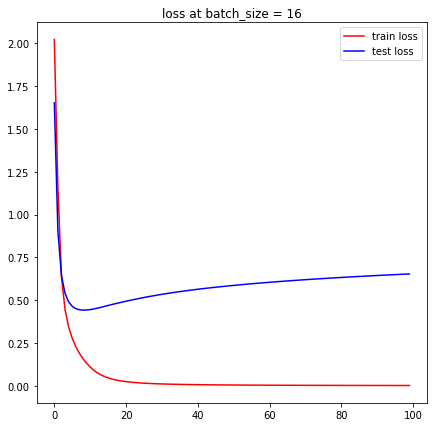

In [39]:
plt.figure(figsize = (7,7))
plt.plot(batch_train_loss[0], c = "red", label = "train loss")
plt.plot(batch_test_loss[0], c = "blue", label = "test loss")
plt.title("loss at batch_size = 16")
plt.legend(loc = "best")
plt.show()

# **[Output] Plot the training and testing accuracies with a batch size of 16**

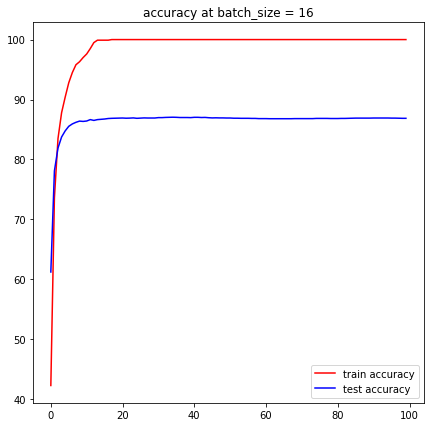

In [40]:
plt.figure(figsize = (7,7))
plt.plot(batch_train_accuracy[0], c = "red", label = "train accuracy")
plt.plot(batch_test_accuracy[0], c = "blue", label = "test accuracy")
plt.title("accuracy at batch_size = 16")
plt.legend(loc = "best")
plt.show()

# **[Output] Plot the training and testing losses with a batch size of 32**

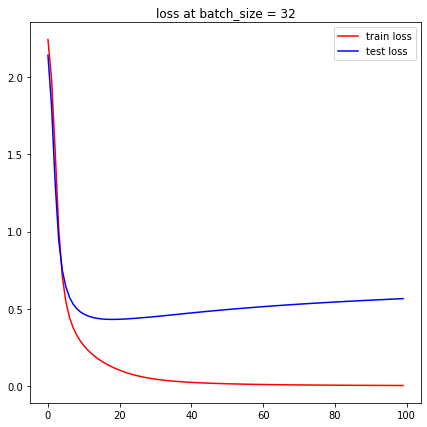

In [41]:
plt.figure(figsize = (7,7))
plt.plot(batch_train_loss[1], c = "red", label = "train loss")
plt.plot(batch_test_loss[1], c = "blue", label = "test loss")
plt.title("loss at batch_size = 32")
plt.legend(loc = "best")
plt.show()

# **[Output] Plot the training and testing accuracies with a batch size of 32**

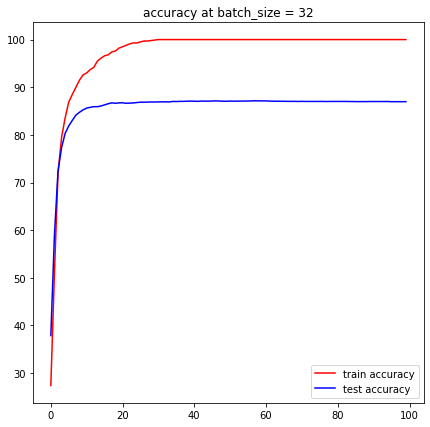

In [42]:
plt.figure(figsize = (7,7))
plt.plot(batch_train_accuracy[1], c = "red", label = "train accuracy")
plt.plot(batch_test_accuracy[1], c = "blue", label = "test accuracy")
plt.title("accuracy at batch_size = 32")
plt.legend(loc = "best")
plt.show()

# **[Output] Plot the training and testing losses with a batch size of 128**

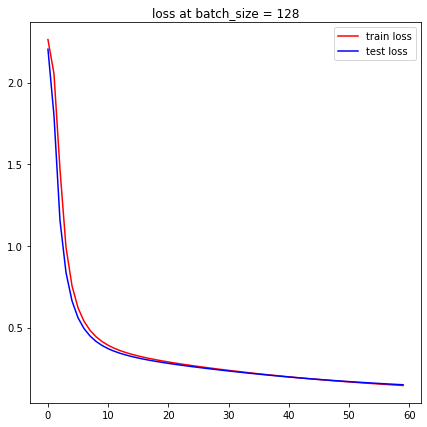

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(batch_train_loss[2], c = "red", label = "train loss")
plt.plot(batch_test_loss[2], c = "blue", label = "test loss")
plt.title("loss at batch_size = 128")
plt.legend(loc = "best")
plt.show()

# **[Output] Plot the training and testing accuracies with a batch size of 128**

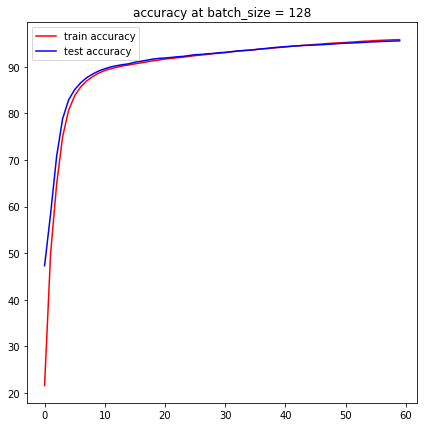

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(batch_train_accuracy[2], c = "red", label = "train accuracy")
plt.plot(batch_test_accuracy[2], c = "blue", label = "test accuracy")
plt.title("accuracy at batch_size = 128")
plt.legend(loc = "best")
plt.show()

# **[Output] Print the loss at convergence with different mini-batch sizes**

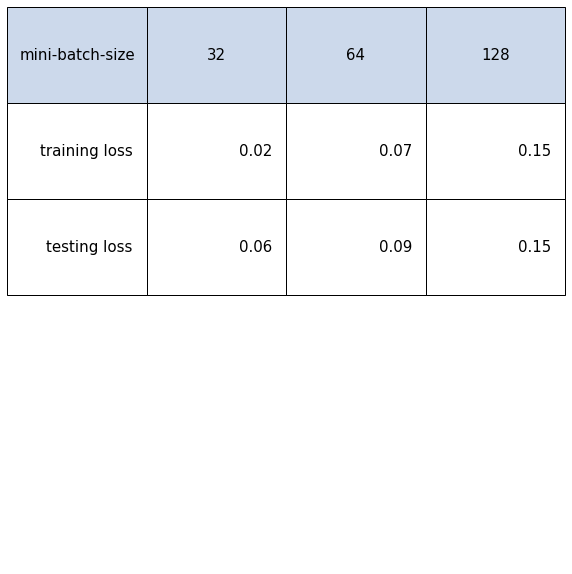

In [ ]:
columns = ["mini-batch-size","32","64","128"]
cellText = [["training loss", round(batch_train_loss[0][-1],2),
             round(batch_train_loss[1][-1],2), round(batch_train_loss[2][-1],2)],
            ["testing loss", round(batch_test_loss[0][-1],2),
             round(batch_test_loss[1][-1],2), round(batch_test_loss[2][-1],2)]]
colors = ["#ccd9eb","#ccd9eb","#ccd9eb","#ccd9eb"]
fig, ax = plt.subplots(figsize = (5,5))
plt.axis("off")
table = ax.table(cellText = cellText,
                 colLabels = columns,
                 colColours = colors,
                 loc = "top",
                 )
table.set_fontsize(100)
table.scale(2,8)

# **[Output] Print the accuracy at convergence with different mini-batch sizes**

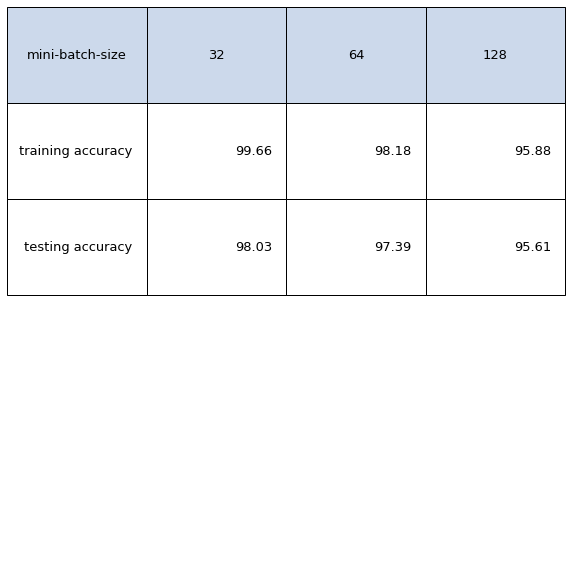

In [ ]:
columns = ["mini-batch-size","32","64","128"]
cellText = [["training accuracy", round(batch_train_accuracy[0][-1],2),
             round(batch_train_accuracy[1][-1],2), round(batch_train_accuracy[2][-1],2)],
            ["testing accuracy", round(batch_test_accuracy[0][-1],2),
             round(batch_test_accuracy[1][-1],2), round(batch_test_accuracy[2][-1],2)]]
colors = ["#ccd9eb","#ccd9eb","#ccd9eb","#ccd9eb"]
fig, ax = plt.subplots(figsize = (5,5))
plt.axis("off")
table = ax.table(cellText = cellText,
                 colLabels = columns,
                 colColours = colors,
                 loc = "top"
                 )
table.set_fontsize(100)
table.scale(2,8)